# <center>Oil Properties Estimation</center>

### <center>Sept 2014<br>Author: Bill Lehr<br>Edited By: James L. Makela</center>

## <u>Minimum Requirements</u>

Adios 3 requires certain minimum amounts of data for any oil to be included in the library

Crude Oil:
<ul>
<li>API and/or density at a reference temperature</li>
<li>Viscosity (either kinematic or dynamic) at a reference temperature</li>
</ul>

Refined Product or 'Other' oil:
<ul>
<li>API and/or density at a reference temperature</li>
<li>Viscosity (either kinematic or dynamic) at a reference temperature</li>
<li>At least three distillation cuts giving mass or volume fraction at boiling(bubble) point</li>
</ul>

Unlike Adios 2, Adios 3 stores both structural and distillation fractional components <b><u>(see figure 1)</u></b>.
Certain properties are valid for the whole oil while others may be defined for each structural fraction and still others vary for both the distillation and chemical structural fraction.

The SQL oil database needs a complete set of oil data.  If measured data exists, it takes priority over estimated values.  Many of the more complex estimation formulas are based upon Adios 2 calculations and/or the following reference:

<b><i>Characterization and Properties of Petroleum Fractions</b></i><br>
<b>Author:</b> Dr. M. R. Riazi, Professor of Chemical Engineering, Kuwait University<br>
<b>Published:</b> 2005<br>
<b>Publisher:</b> American Society for Testing and Materials (ASTM), International<br>
<b>Stock No.:</b> MNL50<br>

This will be abbreviated further in this document as CPPF.

## <u>Setting Up for our Estimations</u>

This is just a bit of setup so that we may verify our estimations with code snippets.

In [1]:
%pylab inline
import numpy as np
from scipy.optimize import curve_fit

import oil_library
from oil_library.models import Oil, ImportedRecord, KVis

session = oil_library._get_db_session()

# these are some reasonable samples of oil records in the oil library
ans_mp = session.query(ImportedRecord).filter(ImportedRecord.oil_name == 'ALASKA NORTH SLOPE (MIDDLE PIPELINE)').one()
ans_2002 = session.query(ImportedRecord).filter(ImportedRecord.oil_name == 'ALASKA NORTH SLOPE (2002)').one()
bahia = session.query(ImportedRecord).filter(ImportedRecord.oil_name == 'BAHIA').one()
arabian = session.query(ImportedRecord).filter(ImportedRecord.oil_name == 'ARABIAN MEDIUM, AMOCO').one()

# These samples are problematic in some way or another
canola = session.query(ImportedRecord).filter(ImportedRecord.oil_name == 'CANOLA OIL (REFERENCE)').one()
abu_safah = session.query(ImportedRecord).filter(ImportedRecord.oil_name == 'ABU SAFAH').one()
sajaa = session.query(ImportedRecord).filter(ImportedRecord.oil_name == 'SAJAA CONDENSATE, BP').one()
bontang = session.query(ImportedRecord).filter(ImportedRecord.oil_name == 'BONTANG MIX, BP').one()
geisum = session.query(ImportedRecord).filter(ImportedRecord.oil_name == 'NORTH GEISUM, GEISUM OIL').one()
cl_bitumen = session.query(ImportedRecord).filter(ImportedRecord.oil_name == 'COLD LAKE BITUMEN').one()
bonny_light = session.query(ImportedRecord).filter(ImportedRecord.oil_name == 'BONNY LIGHT').one()
petro_star = session.query(ImportedRecord).filter(ImportedRecord.oil_name ==
                                                  'FUEL OIL NO.1 (DIESEL/HEATING FUEL), PETRO STAR').one()

print ans_mp
print ans_2002
print bahia
print arabian
print canola


Populating the interactive namespace from numpy and matplotlib
<ImportedRecord('ALASKA NORTH SLOPE (MIDDLE PIPELINE)')>
<ImportedRecord('ALASKA NORTH SLOPE (2002)')>
<ImportedRecord('BAHIA')>
<ImportedRecord('ARABIAN MEDIUM, AMOCO')>
<ImportedRecord('CANOLA OIL (REFERENCE)')>


## <u>Procedural Order of Oil Estimation</u>

Our estimations of properties for an input oil record are based on a set of minimal data requirements.
We necessarily build upon this minimal set in an ordered fashion because some calculations are needed to provide input to later calculations.

If we could describe the general flow of calculations it might be something like this.

- Foundational Aggregate Oil Properties
- Oil Distillation Fractional Properties
- Oil SARA Component Properties
- Oil Miscellaneous Properties

## <u>Foundational Aggregate Oil Properties</u>

These are the baseline oil property estimations which take the properties supplied by the input oil record and produce the minimum set of whole oil properties necessary to estimate the more complex properties, such as the distillation fractions and SARA component properties.  These are:

- Density
- API
- Viscosity

### 1. Density:

(A) If no density value exists, estimate it from the oil's API using the following equation:

$$
\begin{align}
\rho0_{oil} &= \text{density of the oil at a } T_{ref} \text{of } 288.15^\circ K \,\, (kg/m^3) \cr
&= {141.5 \over 131.5 + API} \cdot 1000 \qquad \qquad \qquad \qquad \qquad \qquad \boldsymbol{(eq. 1)} \cr
\end{align}
$$

(B) If a density measurement $\rho_0$ at some temperature $T_0$ exists, but no API, then (eq. 1) can be inverted to give an API.

$$
\begin{align}
API &= \left( {141.5 \over \rho0_{oil}} \cdot 1000 \right) - 131.5 
\qquad \qquad \qquad \qquad \qquad \boldsymbol{(eq. 2)} \cr
\end{align}
$$

But this can only be done after the density value has been adjusted to be a density at $T_{ref} = 288.15^\circ K (15^\circ C)$.  The density conversion formula for different temperatures is:

$$
\begin{align}
\rho_0 &= \text{measured density} \cr
T_0 &= \text{temperature at which density is measured} \cr
k_{\rho T} &= 0.008 K^{-1} \cr
\cr
\rho_{ref} &= \rho_0 \cdot (1 - k_{\rho T} \cdot (T_{ref} - T_0 ))
\qquad \qquad \qquad \qquad \qquad \boldsymbol{(eq. 3)} \cr
\end{align}
$$

<i>(Referenced Source: Adios2)</i>

In [2]:
def lowest_temperature(obj_list):
    '''
        General utility function.

        From a list of objects containing a ref_temp_k attribute,
        return the object that has the lowest temperature
    '''
    if len(obj_list) > 0:
        return sorted(obj_list, key=lambda d: d.ref_temp_k)[0]
    else:
        return None

def closest_to_temperature(obj_list, temperature):
    '''
        General Utility Function

        From a list of objects containing a ref_temp_k attribute,
        return the object that is closest to the specified temperature
    '''
    temp_diffs = [(obj, abs(obj.ref_temp_k - temperature))
                  for obj in obj_list
                  if obj.ref_temp_k is not None]
    if len(temp_diffs) > 0:
        return sorted(temp_diffs, key=lambda d: d[1])[0][0]
    else:
        return None

def estimate_density_from_api(api):
    kg_m_3 = 141.5 / (131.5 + api) * 1000.0
    ref_temp_k = 273.15 + 15.0

    return kg_m_3, ref_temp_k

def estimate_api_from_density(density):
    return (141.5 / density * 1000.0) - 131.5
    
def estimate_density_at_temp(ref_density, ref_temp_k,
                             temperature):
    k_pt = 0.008
    return ref_density / (1 - k_pt * (ref_temp_k - temperature))

def oil_density_at_temp(imported_rec, temperature, weathering=0.0):
    density_list = [d for d in imported_rec.densities
                    if (d.kg_m_3 is not None and
                        d.ref_temp_k is not None and
                        d.weathering == weathering)]
    closest_density = closest_to_temperature(density_list, temperature)
    
    if closest_density is not None:
        d_ref, t_ref = (closest_density.kg_m_3,
                        closest_density.ref_temp_k)
    elif imported_rec.api is not None:
        d_ref, t_ref = estimate_density_from_api(imported_rec.api)
    else:
        return None

    return estimate_density_at_temp(d_ref, t_ref, temperature)

#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'oil.api = ', obj.api
    print 'oil.densities = ', obj.densities

    if obj.api is not None:
        print 'density(api) = ', estimate_density_from_api(obj.api)
    else:
        print 'density(api) = N/A'

    if len(obj.densities) > 0:
        print 'API(density) = ', estimate_api_from_density(oil_density_at_temp(obj, 288.15))
    else:
        print 'API(density) = N/A'

    print 'density at 288.15K = ', (oil_density_at_temp(obj, 288.15), 288.15)
    print

oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
oil.api =  29.9
oil.densities =  [<Density(886.9 kg/m^3 at 273.15K)>, <Density(876.1 kg/m^3 at 288.15K)>]
density(api) =  (876.7038413878562, 288.15)
API(density) =  30.0112430088
density at 288.15K =  (876.1, 288.15)



### 2. Kinematic Viscosity:

The input oil record could contain a number of viscosity properties, measured as either dynamic viscosity, kinematic viscosity, or a mix of both.  Each viscosity property in the oil record is accompanied by a reference temperature $\,^\circ K$ which is the temperature at which the viscosity was measured at.  We want to deal exclusively in kinematic viscosity.

Converting a dynamic viscosity value into a kinematic viscosity value is done as follows.

$$
\begin{align}
\eta 0_{oil} &= \text{measured dynamic viscosity } (kg/(m \cdot s)) \cr
\rho 0_{oil} &= \text{measured density } (kg/m^3) \cr
\cr
v0_{oil} &= \text{kinematic viscosity } (m^2/s) \cr
&= {\eta 0_{oil} \over \rho 0_{oil} }
\qquad \qquad \qquad \qquad \qquad \qquad \boldsymbol{(eq. 4)} \cr
\end{align}
$$

Basically we want to take advantage of any and all measured viscosities that are available.  We will of course prefer the kinematic measurements, but we will want to use any dynamic viscosity measurements that are not redundant.  So the basic program flow will be as follows:

<ul>
<li>Collect all existing measured kinematic viscosities and their associated reference temperatures</li>
<li>Collect any dynamic viscosities measured at temperatures not already represented in the kinematic measurements</li>
<li>Convert the dynamic viscosities into kinematic viscosities using (eq. 3)</li>
<li>Combine our kinematic and converted dynamic viscosities into one aggregate list</li>
</ul>

Using the measured kinematic viscosities, we should be able to estimate the oil kinematic viscosity at an arbitrary temperature.  I believe this is what Adios2 does:
$$
\begin{align}
T &= \text{temperature in } \,^\circ K \cr
k_{v2} &= 5000^\circ K \cr
T_{ref} &= \text{measured reference temperature} \cr
v_{ref} &= \text{measured reference viscosity} \cr
\cr
v_T &= \text{the viscosity at a specified temperature} \cr
&= v_{ref} \cdot exp \left( {k_{v2} \over T} - {k_{v2} \over T_{ref}} \right)
\qquad \qquad \qquad \qquad \qquad \qquad \boldsymbol{(eq. 5)} \cr
\end{align}
$$

In [3]:
def dvis_to_kvis(dvis, density):
    return dvis / density

def estimate_kvis_at_temp(temp_k, kvis_ref, ref_temp_k):
    k_v2 = 5000.0
    return kvis_ref * np.exp(k_v2 / temp_k - k_v2 / ref_temp_k)

def oil_aggregate_kvis(imported_rec):
    kvis_list = [(k.ref_temp_k, k.m_2_s)
                 for k in imported_rec.kvis
                 if k.m_2_s is not None and
                 k.ref_temp_k is not None]
    dvis_list = [(d.ref_temp_k,
                  dvis_to_kvis(d.kg_ms,
                               oil_density_at_temp(imported_rec, d.ref_temp_k)))
                 for d in imported_rec.dvis
                 if d.kg_ms is not None and
                 d.ref_temp_k is not None]

    agg = dict(dvis_list)
    agg.update(kvis_list)

    return [KVis(ref_temp_k=i[0], m_2_s=i[1]) 
            for i in agg.iteritems()]

def oil_kvis_at_temp(imported_rec, temp_k, weathering=0.0):
    kvis_list = [kv for kv in oil_aggregate_kvis(imported_rec)
                 if (kv.weathering == weathering)]
    closest_kvis = closest_to_temperature(kvis_list, temp_k)

    if closest_kvis is not None:
        kvis_ref, t_ref = (closest_kvis.m_2_s,
                           closest_kvis.ref_temp_k)
    else:
        return None

    return estimate_kvis_at_temp(temp_k, kvis_ref, t_ref)

#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'oil.kvis = ', obj.kvis
    print 'oil.dvis = ', obj.dvis
    print 'aggregate kvis = ', oil_aggregate_kvis(obj)
    print 'kvis at 288k = ', oil_kvis_at_temp(obj, 288.0)
    print

# TODO: Okay, the ANS (2002) oil record has a crazy list of dynamic viscosities
#       This has got to be fixed.

oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
oil.kvis =  []
oil.dvis =  [<DVis(0.034 kg/ms at 273.15K)>, <DVis(0.016 kg/ms at 288.15K)>]
aggregate kvis =  [<KVis(3.83357762995e-05 m^2/s at 273.15K)>, <KVis(1.82627553932e-05 m^2/s at 288.15K)>]
kvis at 288k =  1.84285538212e-05



## <u>Oil Distillation Fractional Properties</u>

A large number of our estimations depend upon a characterization of the fractional amounts of compounds that fit somewhere in a high level classification named SARA.  SARA is an acronym meaning Saturates, Aromatics, Resins, and Asphaltenes.  There is much literature on the characterization of these petroleum hydrocarbons, but generally:

- Saturates are volatile, and evaporate at an estimable rate with increasing temperature.
- Aromatics are similarly volatile, but at different rates.
- Resins are considered inert.  That is to say they will not evaporate at any reasonable temperature.
- Asphaltenes are also considered inert.

Most oil records do not contain precise information regarding these fractional amounts.  But they do often contain fractional distillation cut properties.  The distillation cuts describe the rate at which the volatile portions of the oil evaporate.  And from this we can attempt to estimate the SARA fractional amounts.

The steps involved in getting our distillation data are as follows:

- We will first get the fraction of the oil that is inert.  That is the resins and asphaltenes.
- We will then get the data points that represent the fractions of oil that are evaporated at associated temperatures.
- We will then try to normalize the inert and volatile fractions so that they measure up to the total fraction of oil.

### 3. Initial Resin and Asphaltene Fractions and Densities:

<i>
Reference: Fingas empirical formulas that are based upon analysis of ESTC oil properties database.
</i>

If the imported oil record contains valid values for resins and asphaltenes, we will use those values when building our oil.<br>
Otherwise, we will need to estimate them.

First we define some values $A$ and $B$ that will be used for our component fraction formulas:

$$
\begin{align}
\rho 0_{oil} &= \text{oil aggregate density at } 288.15^\circ K \text{  (from eqs. 1,2)} \cr
v0_{oil} &= \text{oil kinematic viscosity at } 288.15^\circ K \text{  (from eq. 5)} \cr
\cr
A &= 10 \cdot exp(0.001 \cdot \rho 0_{oil}) \qquad \qquad \qquad \qquad \boldsymbol{(eq. 6)} \cr
B &= 10 \cdot ln(1000 \cdot \rho 0_{oil} \cdot v0_{oil}) \qquad \qquad \qquad \boldsymbol{(eq. 7)}\cr
\end{align}
$$

Then our component fraction formulas:

$$
\begin{align}
f_{res} &= (0.033 \cdot A + 0.00087 \cdot B - 0.74)_{\bot 0}^{\top 1}
\qquad \qquad \qquad \qquad \qquad \boldsymbol{(eq. 8)} \cr
f_{asph} &= (0.000014 \cdot A^3 + 0.000004 \cdot B^2 - 0.18)_{\bot 0}^{\top (1 - f_{res})}
\qquad \qquad \qquad \boldsymbol{(eq. 9)} \cr
\end{align}
$$

In [4]:
def estimate_A_coeff(density):
    return 10.0 * np.exp(0.001 * density)

def estimate_B_coeff(density, viscosity):
    return 10.0 * np.log(1000.0 * density * viscosity)

def estimate_resin_fraction(density, viscosity, f_other=0.0):
    A = estimate_A_coeff(density)
    B = estimate_B_coeff(density, viscosity)

    f_res = 0.033 * A + 0.00087 * B - 0.74
    f_res = np.clip(f_res, 0.0, 1.0 - f_other)
    
    return f_res


def estimate_asphaltene_fraction(density, viscosity, f_other=0.0):
    A = estimate_A_coeff(density)
    B = estimate_B_coeff(density, viscosity)

    f_asph = (0.000014 * A ** 3.0 +
              0.000004 * B ** 2.0 -
              0.18)
    f_asph = np.clip(f_asph, 0.0, 1.0 - f_other)
    
    return f_asph

def oil_inert_fractions(imported_rec):
    f_res, f_asph = imported_rec.resins, imported_rec.asphaltenes

    if f_res is not None and f_asph is not None:
        return f_res, f_asph
    else:
        density = oil_density_at_temp(imported_rec, 288.15)
        viscosity = oil_kvis_at_temp(imported_rec, 288.15)

    if f_res is None:
        f_res = estimate_resin_fraction(density, viscosity)

    if f_asph is None:
        f_asph = estimate_asphaltene_fraction(density, viscosity,
                                              f_res)

    return f_res, f_asph

#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'oil.api = ', obj.api
    print 'oil.resins = ', obj.resins
    print 'oil.asphaltenes = ', obj.asphaltenes
    obj_density = oil_density_at_temp(obj, 288.15)
    obj_viscosity = oil_kvis_at_temp(obj, 288.15)
    print 'oil density at temp = ', obj_density
    print 'oil viscosity at temp = ', obj_viscosity
    print 'f_res, f_asph = ',
    print estimate_resin_fraction(obj_density, obj_viscosity),
    print estimate_asphaltene_fraction(obj_density, obj_viscosity)
    print 'f_res, f_asph = ', oil_inert_fractions(obj)
    print 'sum of inert fractions = ', np.sum(oil_inert_fractions(obj))
    print


oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
oil.api =  29.9
oil.resins =  None
oil.asphaltenes =  None
oil density at temp =  876.1
oil viscosity at temp =  1.82627553932e-05
f_res, f_asph =  0.0766216397354 0.0169777627026
f_res, f_asph =  (0.076621639735448888, 0.016977762702612892)
sum of inert fractions =  0.0935994024381



### 4. Distillation Cut Boiling Point:

<i>
<b>Reference:</b> Adios2 and Jones R. (1997), A Simplified Pseudo-component Oil Evaporation Model, Proceedings of the 20th Arctic and Marine Oil Spill Program (AMOP), Vancouver, CA, Vol. 1, pp. 43-62
</i>

If the oil record contains distillation data, then we can use the distillation cut temperatures.<br>
Otherwise, if no distillation data exists, then we can estimate the distillation data from the oil's API.

This is done as follows:

First we estimate our lower and upper temperature bounds:

$$
\begin{align}
T_0 &= \text{the lower temperature boundary} \cr
&= 457 - 3.34 \cdot API \qquad \qquad \qquad \qquad \boldsymbol{(eq. 10)} \cr
T_G &= \text{the upper temperature boundary} \cr
&= 1357 - 247.7 \cdot ln(API) \qquad \qquad \qquad \boldsymbol{(eq. 11)} \cr
\end{align}
$$

Next, we would like to generate a set of $N$ temperatures associated with our cuts $T_i$.  We will use a default of 5 cuts for this.

$$
\begin{align}
N &= 5 \cr
T_i &= T_0 + T_G \cdot {i \over N} \quad \{ i \in \Bbb Z \,\,|\,\, 0 \leq i < N \}
\qquad \boldsymbol{(eq. 12)} \cr
\end{align}
$$

In [5]:
def estimate_cut_temps_from_api(api, N=5):
    T_0 = 457.0 - 3.34 * api
    T_G = 1357.0 - 247.7 * np.log(api)
    
    return np.array([(T_0 + T_G * i / N)
                     for i in range(N)])

def oil_cut_temps(imported_rec):
    culled_cuts = imported_rec.cuts
    if len(culled_cuts) > 0:
        return np.array([c.vapor_temp_k
                         for c in culled_cuts])
    elif imported_rec.api is not None:
        return estimate_cut_temps_from_api(imported_rec.api)
    else:
        est_api = estimate_api_from_density(oil_density_at_temp(imported_rec, 288.15))
        return estimate_cut_temps_from_api(est_api)

#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'oil.api = ', obj.api
    print 'oil.densities = ', obj.densities
    print 'oil.cut.vapor_temp_k = ', [c.vapor_temp_k for c in obj.cuts]
    print 'oil.cut.fraction = ', [c.fraction for c in obj.cuts]
    print 'cut temperatures = ', oil_cut_temps(obj)
    print


oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
oil.api =  29.9
oil.densities =  [<Density(886.9 kg/m^3 at 273.15K)>, <Density(876.1 kg/m^3 at 288.15K)>]
oil.cut.vapor_temp_k =  [313.15, 353.15, 393.15, 433.15, 473.15, 573.15, 673.15, 773.15, 873.15, 973.15]
oil.cut.fraction =  [0.03, 0.07, 0.13, 0.19, 0.25, 0.42, 0.6, 0.76, 0.88, 0.95]
cut temperatures =  [ 313.15  353.15  393.15  433.15  473.15  573.15  673.15  773.15  873.15
  973.15]



### 5. Distillation Cut Mass Fraction:

The distillation cuts are a series of temperatures and mass fractions.  And each temperature $T_i$ is associated with a fractional value $fevap_i$ representing the portion of substance that was evaporated at that temperature. 

For any temperature below about $530^\circ K$, we can assume that the portion of substance that was evaporated contains a mix of saturates and aromatics, and that no resins or asphaltenes have been released.
The fractional quantity that was evaporated at a distillation cut temperature, is what we would like to consider to be our distillation cut mass fractions.

<b>(A)</b> If the oil record contains at least two distillation cuts exist for which $T_i < 530^\circ K$, then we will use the supplied distillation cut fractional masses to generate $fmass_i$.

The distillation cut mass fractions that we get in the imported oil record are cumulative in nature, so it is necessary to collect the differences in the distillation cut mass fractions when generating $fmass_i$

$$
\begin{align}
fmass_i &= {d \over di} \left( fevap_i \right)
\qquad \{ i \in \Bbb Z \,\,|\,\, 0 \leq i \leq N \}
\qquad \qquad \boldsymbol{(eq. 13)} \cr
\end{align}
$$

<b>(B)</b> If distillation cut temperatures were generated by approximation (eq. 18), then it can be assumed that there were no measured mass fractions.  For this we will evenly distribute our fractional masses such that for all distillation cuts:

$$
\begin{align}
fmass_i &= {(1 - (f_{res} + f_{asph})) \over N}
\qquad \qquad \boldsymbol{(eq. 14)} \cr
\end{align}
$$

In [6]:
def estimate_fmasses_from_cuts(f_evap_i):
    fmass_i = np.array(f_evap_i)
    fmass_i[1:] = np.diff(fmass_i)

    return fmass_i

def estimate_n_fmasses(f_res, f_asph, N=5):
    return np.array([(1.0 - f_res - f_asph) / N] * N)

def oil_fmasses(imported_rec):
    f_res, f_asph = oil_inert_fractions(imported_rec)
    culled_cuts = imported_rec.cuts

    if len(culled_cuts) > 0:
        fractions = [c.fraction for c in culled_cuts]
        return estimate_fmasses_from_cuts(fractions)
    else:
        return estimate_n_fmasses(f_res, f_asph)

#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'oil cut temps = ', oil_cut_temps(obj)
    fractions = [c.fraction for c in obj.cuts]
    print 'oil.cuts.fractions = ', fractions
    f_res, f_asph = oil_inert_fractions(obj)
    print 'f_res, f_asph = ', f_res, f_asph

    fmasses = estimate_fmasses_from_cuts(fractions)
    print 'sum(fmasses) = ', np.sum(fmasses) + f_res + f_asph

    fmasses = estimate_n_fmasses(f_res, f_asph)
    print 'sum(N fmasses) = ', np.sum(fmasses) + f_res + f_asph
    
    fmasses = oil_fmasses(obj)
    print 'sum(oil_fmasses()) = ', np.sum(fmasses) + f_res + f_asph
    print


oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
oil cut temps =  [ 313.15  353.15  393.15  433.15  473.15  573.15  673.15  773.15  873.15
  973.15]
oil.cuts.fractions =  [0.03, 0.07, 0.13, 0.19, 0.25, 0.42, 0.6, 0.76, 0.88, 0.95]
f_res, f_asph =  0.0766216397354 0.0169777627026
sum(fmasses) =  1.04359940244
sum(N fmasses) =  1.0
sum(oil_fmasses()) =  1.04359940244



### 16. Normalizing our Distillation Cut Data:

Because there are so many calculations that propagate from the distillation cuts, it is important that we interpret them in such a way that results in a reasonable, or at least plausible, distillation curve.  And since we are dealing with records that were manually entered into a database, data entry errors need to be anticipated.

We expect the evaporated fractions to be cumulative with rising temperature.  And if someone incorrectly entered a value when generating the imported oil record, then our cut data could fail to follow this cumulative trend, and our evaporation curve is thrown off.  Some specific errors and their implications are:

- <b>Smaller fraction</b> entered than what it should have been: This will likely cause the fraction to be smaller than the previous one, and the $fmass_i$ value will go negative.
- <b>Bigger fraction</b> entered than what it should have been: This will likely cause the next fraction to be smaller, and the next $fmass_i$ value will go negative.
- <b>Smaller temperature</b> entered than what it should have been: Optimistically the series of $(T_i, fevap_i)$ could be reordered by temperature.  But if we reorder a mistaken temperature, then the fraction will be mistakenly reordered as well, and the error will manifest itself in a similar way as a <b>bigger fraction</b>.

I don't think we can treat this in a naive way.  

- We need to treat the temperatures and their associated fractions as atomic units of data
- Temperatures are required to be in ascending order.  If the temperature of a particular cut is lower than the previous, we throw out the cut.
- Cut fractions might seem to be less consequential.  This will happen only once per error in the series, and we could simply clip the value to be $\geq 0$.  But this will have implications in that the sum of the differences will add up to something bigger than the total evaporated amount, which we don't want.  It's probably better to just throw out the cut.

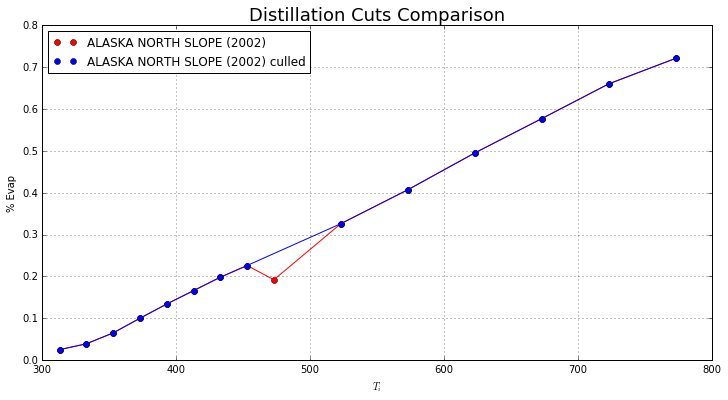

In [7]:
def oil_culled_cuts(imported_rec):
    prev_temp = prev_fraction = 0.0
    for c in imported_rec.cuts:
        if c.vapor_temp_k < prev_temp:
            continue

        if c.fraction < prev_fraction:
            continue

        prev_temp = c.vapor_temp_k
        prev_fraction = c.fraction

        yield c

# we need to redefine our cut temperatures function
# to utilize our culled cuts instead of raw cuts.
def oil_cut_temps(imported_rec):
    culled_cuts = list(oil_culled_cuts(imported_rec))

    if len(culled_cuts) > 0:
        return np.array([c.vapor_temp_k
                         for c in culled_cuts])
    elif imported_rec.api is not None:
        return estimate_cut_temps_from_api(imported_rec.api)
    else:
        est_api = estimate_api_from_density(oil_density_at_temp(imported_rec, 288.15))
        return estimate_cut_temps_from_api(est_api)

# we need to redefine our cut fractions function
# to utilize our culled cuts instead of raw cuts.
def oil_fmasses(imported_rec):
    f_res, f_asph = oil_inert_fractions(imported_rec)
    culled_cuts = list(oil_culled_cuts(imported_rec))

    if len(culled_cuts) > 0:
        fractions = [c.fraction for c in culled_cuts]
        return estimate_fmasses_from_cuts(f_res, f_asph,
                                          fractions
                                          )
    else:
        return estimate_n_fmasses(f_res, f_asph)

obj = ans_2002
plt.figure(1, figsize=(12,6))
plt.subplot(111)

plt.plot(*zip(*[(c.vapor_temp_k, c.fraction) for c in obj.cuts]) + ['ro'],
         label=ans_2002.oil_name)
plt.plot(*zip(*[(c.vapor_temp_k, c.fraction) for c in obj.cuts]) + ['r-'])

plt.plot(*zip(*[(c.vapor_temp_k, c.fraction) for c in oil_culled_cuts(obj)]) + ['bo'],
         label=ans_2002.oil_name + ' culled')
plt.plot(*zip(*[(c.vapor_temp_k, c.fraction) for c in oil_culled_cuts(obj)]) + ['b-'])

plt.xlabel(r'$T_i$')
plt.ylabel('% Evap')
plt.grid()
plt.title(r'Distillation Cuts Comparison', fontsize=18)

plt.legend(loc='upper left')

Not only do we seem to have typographic errors in the distillation cut data, but we have incomplete representation of distillation.  The cut data of some oil records have a maximum distillation amount that is considerably less than the total oil, and the inert fractions, calculated or read from the record, do not account for a complete fraction (1.0) of oil mass.

I will suggest this for our distillation curves.  I think we need to calculate the maximum amount we expect to be evaporated with our distillation cuts.  Call it $fevap_{max}$.  We can obtain this from the following equation:
$$
\begin{align}
fevap_{max} &= 1 - f_{res} - f_{asph} \cr
\end{align}
$$


Then we take the culled distillation cuts that exist, and use them to approximate a linear curve of our fractional distillation.  I believe Bill, Robert, and Chris would agree that the distillation data approximates a linear curve of the form $(ax + b)_{\bot 0}^{\top 1}$.  But just for fun, we will also try a sigmoid.

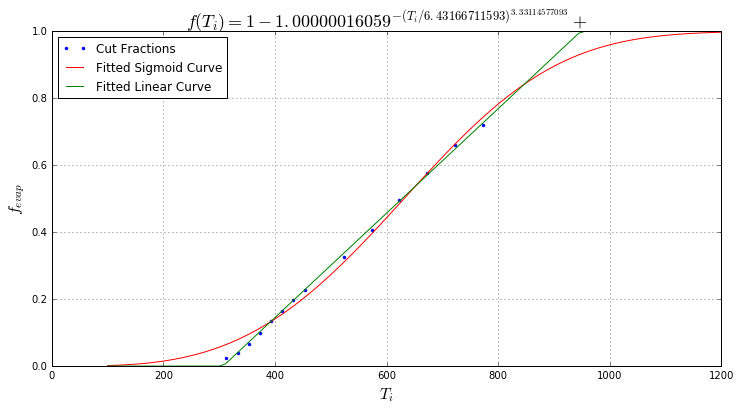

In [8]:
plt.figure(1, figsize=(12,6))
plt.subplot(111)

obj = ans_2002

boiling_points = [c.vapor_temp_k for c in oil_culled_cuts(obj)]
cum_fractions = [c.fraction for c in oil_culled_cuts(obj)]
plt.plot(boiling_points, cum_fractions, '.b', label="Cut Fractions")

plt.xlabel(r'$T_i$', fontsize=16)
plt.ylabel(r'$f_{evap}$', fontsize=16)
plt.grid()

#def func(x, a, b, c, d):
#    return a*x**3 + b*x**2 +c*x + d

def sigmoid(x, j, k, lamb):
    # intuitively, our cut fractions could approximate
    # a similar shape as a cumulative distribution function
    # or sigmoid.
    return (1.0 - j ** (-1.0 * (x / lamb) ** k))

def linear(x, a, b):
    # intuitively, our cut fractions could approximate
    # a similar shape as a linear function.
    return (a * x + b)


new_bps = np.linspace(100., 1200., 100)

"""
    curve_fit the sigmoid
"""
if len(boiling_points) >= 3:
    popt, pcov = curve_fit(sigmoid, boiling_points, cum_fractions)
    plt.title(r'$f(T_i)= '
              '1 - {0}^{{-(T_i / {2})^{{{1}}} }} + '
              '$'.format(*popt),
              fontsize=18)

    # now plot our sigmoid curve with a bunch of boiling points from 273K to 1015K
    plt.plot(new_bps, sigmoid(new_bps, *popt), '-r', label="Fitted Sigmoid Curve")
else:
    print 'not enough data for a sigmoid!'

"""
    curve_fit the linear
"""
popt, pcov = curve_fit(linear, boiling_points, cum_fractions)

# now plot our linear curve with a bunch of boiling points from 273K to 1015K
plt.plot(new_bps, np.clip(linear(new_bps, *popt), 0.0, 1.0), '-g', label="Fitted Linear Curve")

plt.legend(loc='upper left')


Okay, the linear curve seems to fit somewhat better, although it would be interesting to test this with a lot of oils.  We'll go with the linear fit for now.

What we would like to do now is inverse the linear curve function so that it will calculate the temperature at which a certain fraction has boiled off.  Then we can take a set of N fractions that represent equidistant intervals between 0.0 and $fevap_{max}$.

Our inverse linear function looks like this:
$$
\begin{align}
x &= {y - b \over a} \cr
\end{align}
$$

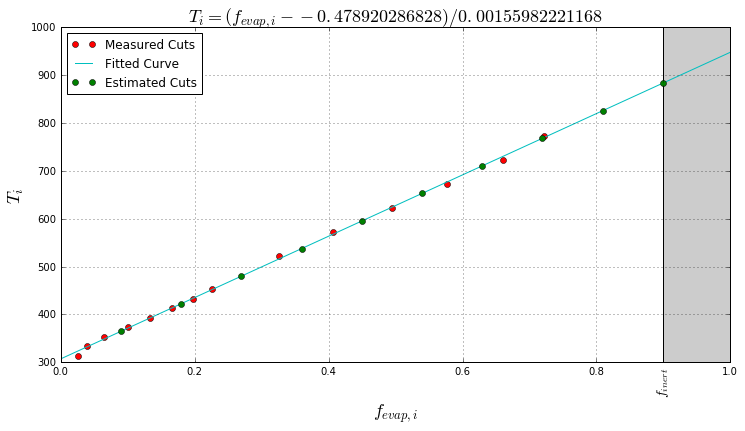

In [10]:
plt.figure(1, figsize=(12,6))
ax = plt.subplot(111)

obj = ans_2002
#print list(oil_culled_cuts(ans_2002))
num_cuts = 10
boiling_points = [c.vapor_temp_k for c in oil_culled_cuts(obj)]
cum_fractions = [c.fraction for c in oil_culled_cuts(obj)]
f_res, f_asph = oil_inert_fractions(obj)


'''
    plot the cut points
'''
plt.plot(cum_fractions, boiling_points, 'ro', label="Measured Cuts")

plt.xlabel(r'$f_{evap,i}$', fontsize=18)
plt.ylabel(r'$T_i$', fontsize=18)
plt.grid()

def linear(x, a, b):
    return (a * x + b)

def inverse_linear(y, a, b):
    return (y - b) / a

"""
    curve_fit the linear
"""
popt, pcov = curve_fit(linear, boiling_points, cum_fractions)
plt.title(r'$T_i = '
          '(f_{{evap,i}} - {1}) / {0}'
          '$'.format(*popt),
          fontsize=18)

# now plot our inverse linear curve with a bunch of fractions from 0.0001 to 0.9999
new_fracs = np.linspace(0.0001, 0.9999, 100)
plt.plot(new_fracs, inverse_linear(new_fracs, *popt), '-c', label="Fitted Curve")

# now plot our inverse linear curve with the N fractions we intend to use
new_fracs = np.linspace(0.0, 1.0 - f_res - f_asph, num_cuts + 1)[1:]
plt.plot(new_fracs, inverse_linear(new_fracs, *popt), 'go', label="Estimated Cuts")

# make the shaded region
low, high = 1.0 - f_res - f_asph, 1.0
ix = (low, high)
iy = (1000.0, 1000.0)
verts = [(low,0)] + list(zip(ix,iy)) + [(high,0)]
poly = Polygon(verts, facecolor='0.8', edgecolor='k')
ax.add_patch(poly)

# ticks for the shaded region
extraticks = [low,]
extralabels = [r'${f_{inert}}$',]
plt.xticks(list(plt.xticks()[0]) + extraticks,
           list(plt.xticks()[0]) + extralabels)

for tick in ax.xaxis.get_major_ticks():
    if tick.label.get_text().find('inert') >= 0:
        tick.label.set_fontsize(14)
        tick.label.set_rotation('vertical')

plt.legend(loc='upper left')


Alright, that doesn't look too bad, but we are still missing something.

First, it is possible for us to fit a curve that will give negative kelvin temperatures.  Negative Kelvin temperatures, are of course impossible.  We need to make sure our curve fit anticipates that.

What we have works ok for total evaporated amounts, and differencing them should give us reasonable values for $fmass_i$.  But the temperatures we get from our curve represent only the maximum slice of distilled components within $fmass_i$.  What we really need is the average temperature from $T_{i-1}$ to $T_i$

boiling_points: [313.0, 333.0, 353.0, 373.0, 393.0, 413.0, 433.0, 453.0, 523.0, 573.0, 623.0, 673.0, 723.0, 773.0]
cum_fractions: [0.025, 0.039, 0.065, 0.1, 0.134, 0.166, 0.198, 0.226, 0.326, 0.407, 0.495, 0.577, 0.66, 0.721]
inert_fractions: 0.061 0.04


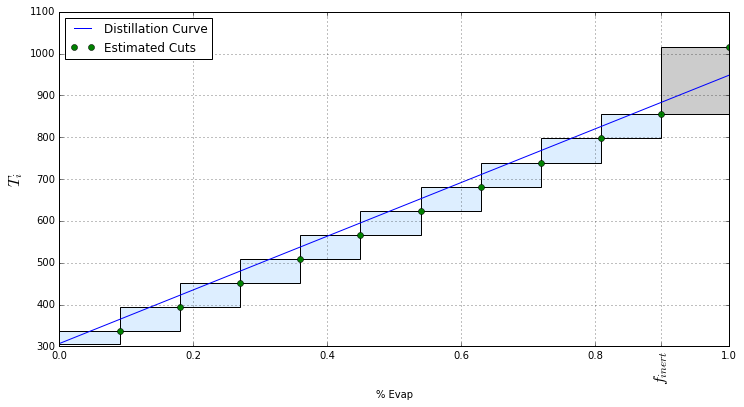

In [11]:
plt.figure(1, figsize=(12,6))
ax = plt.subplot(111)

obj = ans_2002
#print list(oil_culled_cuts(ans_2002))
num_cuts = 10
boiling_points = [c.vapor_temp_k for c in oil_culled_cuts(obj)]
cum_fractions = [c.fraction for c in oil_culled_cuts(obj)]
f_res, f_asph = oil_inert_fractions(obj)
print 'boiling_points:', boiling_points
print 'cum_fractions:', cum_fractions
print 'inert_fractions:', f_res, f_asph

plt.xlabel('% Evap')
plt.ylabel(r'$T_i$', fontsize=16)
plt.grid()

def linear(x, a, b):
    return (a * x + b)

def inverse_linear(y, a, b):
    return (y - b) / a

"""
    curve_fit the linear
"""
popt, pcov = curve_fit(linear, boiling_points, cum_fractions)

# plot our distillation curve
new_fracs = np.linspace(0.0001, 0.9999, 100)
new_temps = np.clip(inverse_linear(new_fracs, *popt), 0.0, 5000.0)
plt.plot(new_fracs, new_temps, '-b', label="Distillation Curve")

# now plot the N fractions we intend to use
new_fracs = np.linspace(0.0, 1.0 - f_res - f_asph, (num_cuts * 2) + 1)[1:]
new_temps = inverse_linear(new_fracs, *popt)

new_fracs = new_fracs.reshape(-1,2)[:,1]
new_temps = new_temps.reshape(-1,2)[:,0]
above_zero = new_temps > 0.0
new_temps = new_temps[above_zero]
new_fracs = new_fracs[above_zero]

plt.plot(new_fracs, new_temps, 'go', label="Estimated Cuts")

# plot our inert fraction
plt.plot(1.0, 1015.0, 'go')

# now we would like to graph the quantized "areas"
# that our fractional masses represent
def make_shaded_region(f_low, f_high,
                       t_low, t_high,
                      facecolor='0.8'):
    ix = (f_low, f_high)
    iy = (t_low, t_high)
    verts = [(x, y) for x in ix for y in iy]
    verts[2:] = reversed(verts[2:])
    poly = Polygon(verts, facecolor=facecolor, edgecolor='k')
    ax.add_patch(poly)

for r in zip([0.0] + new_fracs.tolist(),
             new_fracs,
             [inverse_linear(0.0, *popt)] + new_temps.tolist(),
             new_temps):
    make_shaded_region(*r, facecolor='#ddeeff')

# make the shaded region for our inert fraction
make_shaded_region(new_fracs[-1], 1.0,
                   new_temps[-1], 1015.0)

# ticks for the shaded region
extraticks = [low,]
extralabels = [r'${f_{inert}}$',]
plt.xticks(list(plt.xticks()[0]) + extraticks,
           list(plt.xticks()[0]) + extralabels)

for tick in ax.xaxis.get_major_ticks():
    if tick.label.get_text().find('inert') >= 0:
        tick.label.set_fontsize(16)
        tick.label.set_rotation('vertical')

plt.legend(loc='upper left')


Alright, **now** this looks like a reasonable quantization of our distillation curve.

putting it all together in code...

In [12]:
def linear_curve(x, a, b):
    return (a * x + b)

def inverse_linear_curve(y, a, b):
    return (y - b) / a

def oil_normalized_cut_values(imported_rec, num_cuts=10):
    f_res, f_asph = oil_inert_fractions(imported_rec)
    
    culled_cuts = list(oil_culled_cuts(imported_rec))

    if len(culled_cuts) == 0:
        if imported_rec.api is not None:
            oil_api = imported_rec.api
        else:
            oil_rho = oil_density_at_temp(imported_rec, 288.15)
            oil_api = estimate_api_from_density(oil_rho)

        BP_i = estimate_cut_temps_from_api(oil_api)
        fevap_i = np.cumsum(estimate_n_fmasses(f_res, f_asph))
    else:
        BP_i, fevap_i = zip(*[(c.vapor_temp_k, c.fraction)
                              for c in culled_cuts])

    popt, pcov = curve_fit(linear_curve, BP_i, fevap_i)

    fevap_i = np.linspace(0.0, 1.0 - f_res - f_asph, (num_cuts * 2) + 1)[1:]
    T_i = np.clip(inverse_linear(fevap_i, *popt), 0.0, 5000.0)

    fevap_i = fevap_i.reshape(-1,2)[:,1]
    T_i = T_i.reshape(-1,2)[:,0]

    above_zero = T_i > 0.0
    T_i = T_i[above_zero]
    fevap_i = fevap_i[above_zero]

    return T_i, fevap_i

def oil_normalized_cut_temps(imported_rec, num_cuts=10):
    cut_temps, _f_evap_i = oil_normalized_cut_values(imported_rec)
    
    return cut_temps

def oil_normalized_cut_fmasses(imported_rec, num_cuts=10):
    _cut_temps, f_evap_i = oil_normalized_cut_values(imported_rec)
    
    return estimate_fmasses_from_cuts(f_evap_i)

def oil_normalized_cut_temps_fmasses(imported_rec, num_cuts=10):
    cut_temps, f_evap_i = oil_normalized_cut_values(imported_rec)
    
    return cut_temps, estimate_fmasses_from_cuts(f_evap_i)



#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'oil.api = ', obj.api
    print 'oil cut temps = ', oil_cut_temps(obj)
    fractions = [c.fraction for c in oil_culled_cuts(obj)]
    print 'oil.cuts.fractions = ', fractions
    f_res, f_asph = oil_inert_fractions(obj)
    print 'f_res, f_asph = ', f_res, f_asph
    if len(fractions) > 0:
        print ('sum of all non-normalized fractions = {}'
               .format(fractions[-1] + f_res + f_asph))
    else:
        print 'No measured fractions found.'

    print ('sum of all normalized fmasses = {}'
           .format(np.sum(oil_normalized_cut_fmasses(obj)) + f_res + f_asph))
    print


oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
oil.api =  29.9
oil cut temps =  [ 313.15  353.15  393.15  433.15  473.15  573.15  673.15  773.15  873.15
  973.15]
oil.cuts.fractions =  [0.03, 0.07, 0.13, 0.19, 0.25, 0.42, 0.6, 0.76, 0.88, 0.95]
f_res, f_asph =  0.0766216397354 0.0169777627026
sum of all non-normalized fractions = 1.04359940244
sum of all normalized fmasses = 1.0



## <u>Oil Component Fractional Properties</u>

Once we have estimated the distilled and inert fractions of our oil, we can then begin to break it down even further, into SARA component fractional properties.  This will include:

- Component Molecular Weight
- Component Density
- Component Specific Gravity <i>(basically a representation of density)</i>
- Saturate and Aromatic Mass Fractions <i>(we have already estimated our resins & asphaltenes, and they will not change)</i>

We will organize our components in arrays that are consistently ordered so that all properties of any particular component will share a common index.  The ordering will be as follows:

$$
\begin{align}
[
&C_{sat,0} \, C_{arom,0} \cr
&C_{sat,1} \, C_{arom,1} \cr
&C_{sat,2} \, C_{arom,2} \cr
&... \cr
&C_{sat,N} \, C_{arom,N} \cr
&C_{res} \, C_{asph} ] \cr
\end{align}
$$

### 17. Component Temperatures:

Here we will define a temperature for each of our components.  This is a fairly straight forward copy of the cut temperatures in regards to the saturate and aromatic components.

But our resins and asphaltenes need a temperature too.  We will choose a default value of $1015^\circ K$ for them.

In [13]:
def oil_component_temps(imported_rec):
    cut_temps = oil_normalized_cut_temps(imported_rec)

    component_temps = np.append([1015.0, 1015.0],
                                zip(cut_temps, cut_temps))
    return np.roll(component_temps, -2)


### 18. Initial Component Molecular Weight:

<i>
Reference: CPPF eq. 2.48 and table 2.6
</i>

The saturate and aromatic component molecular weights can be calculated using the distillation cut temperatures as follows:

$$
\begin{align}
M_{w,sat,i} &= \left( 49.677 \cdot \left[ 6.98291 - ln(1070 - T_i) \right] \right)^{3/2}
\qquad \qquad \qquad \boldsymbol{(eq. 15)} \cr
M_{w,arom,i} &= \left( 44.504 \cdot \left[ 6.911 - ln(1015 - T_i) \right] \right)^{3/2}
\qquad \qquad \qquad \boldsymbol{(eq. 16)} \cr
\end{align}
$$

So that we have a full complement of molecular weights for <u>all</u> components, We need some estimation method for our resins and asphaltenes.  Bill recommends using the following average values:
$$
\begin{align}
M_{w,res} &= \text{molecular weight of our resin component} \cr
&= 800 \, g/mol \text{ at } 1015^\circ K \cr
M_{w,asph} &= \text{molecular weight of our asphaltene component} \cr
&= 1000 \, g/mol \text{ at } 1015^\circ K \cr
\end{align}
$$

In [14]:
def estimate_saturate_mol_wt(boiling_point):
    T_i = np.array(boiling_point)
    return (49.677 * (6.98291 - np.log(1070.0 - T_i))) ** (3.0 / 2.0)

def estimate_aromatic_mol_wt(boiling_point):
    T_i = np.array(boiling_point)
    return (44.504 * (6.911 - np.log(1015.0 - T_i))) ** (3.0 / 2.0)

def estimate_resin_mol_wt():
    return 800.0

def estimate_asphaltene_mol_wt():
    return 1000.0

def estimate_component_mol_wt(boiling_points):
    rho_list = np.append([estimate_resin_mol_wt(),
                          estimate_asphaltene_mol_wt()],
                         zip(estimate_saturate_mol_wt(boiling_points),
                             estimate_aromatic_mol_wt(boiling_points)))
    return np.roll(rho_list, -2)

def oil_component_mol_wt(imported_rec):
    cut_temps = oil_normalized_cut_temps(imported_rec)

    return estimate_component_mol_wt(cut_temps)


#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'component mol_wt = ', oil_component_mol_wt(obj).reshape(-1,2)
    print


oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
component mol_wt =  [[   79.87780305    69.12113917]
 [  108.64997116    95.83581338]
 [  143.29934679   128.44923122]
 [  185.03374123   168.31003924]
 [  235.5421871    217.36221559]
 [  297.24730182   278.50203314]
 [  373.75782192   356.26148978]
 [  470.73764917   458.24068943]
 [  597.74261583   598.52643549]
 [  772.66404782   807.61243414]
 [  800.          1000.        ]]



### 19. Component Density:

<i>
Reference: CPPF eq. 2.13 and table 9.6
</i>

Initial density estimate for both resin and asphaltene fractional componens is set to:

$$
\begin{align}
\rho_{res} &= \rho_{asph} = 1100 \, kg/m^3 \cr
\end{align}
$$

Then we define Watson characterization factors for saturates and aromatics:

$$
\begin{align}
K_{arom,w} &= \text{Watson characterization factor for aromatics} \cr
&= 10 \cr
K_{sat,w} &= \text{Watson characterization factor for saturates} \cr
&= 12 \cr
\end{align}
$$

Then we apply the appropriate Watson characterization to calculate an initial trial estimate for each density component:

$$
\begin{align}
T_i &= \text{component boiling point } (\,^\circ K) \cr
\cr
\rho try_{arom,i} &= 1000 \cdot {\root 3 \of { 1.8 \cdot T_i} \over K_{arom,w} }
\qquad \qquad \boldsymbol{(eq. 17)} \cr
\rho try_{sat,i} &= 1000 \cdot {\root 3 \of { 1.8 \cdot T_i} \over K_{sat,w} }
\qquad \qquad \boldsymbol{(eq. 18)} \cr
\end{align}
$$

This should be a reasonable estimate.  However, the average density (fractionally weighted average of the component densities) must match the measured value or the value from approximation (eqs. 1, 2).<br>
To find the scaling factor between our densities and the aggregate density, we do the following:

$$
\begin{align}
j &= \text{index representing all oil components } \{ j \in \Bbb Z \} \cr
jMAX &= \text{index of the last oil component} \cr
&= 2N + 2 \cr
fmass0_j &= \text{the fractional mass of our jth component} \cr
\cr
Cf_{dens} &= { \rho 0_{oil} \over \sum_{j=1}^{jMAX} fmass0_j \cdot \rho try_j}
\qquad \qquad \boldsymbol{(eq. 19)} \cr
\end{align}
$$

Then we evenly apply this scaling factor to our trial densities to come up with densities that are consistent with the aggregate density.

$$
\begin{align}
\rho_j = Cf_{dens} \cdot \rho try_j \qquad \qquad \boldsymbol{(eq. 20)} \cr
\end{align}
$$

<center><b>--- Begin JamesM Comments ---</b></center>

Well, I don't know about the resin & asphaltene densities.  It seems that at the higher temperatures, the Aromatic densities get slightly denser than the inert components.  This doesn't seem right.

<center><b>--- End JamesM Comments ---</b></center>

In [15]:
def estimate_trial_densities(boiling_points, watson_factor):
    return 1000.0 * (1.8 * boiling_points) ** (1.0 / 3.0) / watson_factor

def estimate_saturate_densities(boiling_points):
    return estimate_trial_densities(boiling_points, 12)

def estimate_aromatic_densities(boiling_points):
    return estimate_trial_densities(boiling_points, 10)

def estimate_resin_density():
    return 1100.0

def estimate_asphaltene_density():
    return 1100.0

def estimate_component_densities(boiling_points):
    rho_list = np.append([estimate_resin_density(),
                          estimate_asphaltene_density()],
                         zip(estimate_saturate_densities(boiling_points),
                             estimate_aromatic_densities(boiling_points)))
    return np.roll(rho_list, -2)

def oil_component_densities(imported_rec):
    cut_temps = oil_normalized_cut_temps(imported_rec)
    return estimate_component_densities(cut_temps)
    

#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'component densities from oil = ', oil_component_densities(obj).reshape(-1, 2)
    print


oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
component densities from oil =  [[  698.98635463   838.78362555]
 [  739.55939262   887.47127114]
 [  776.11098612   931.33318334]
 [  809.51024975   971.41229971]
 [  840.3598753   1008.43185036]
 [  869.09696831  1042.91636197]
 [  896.04981383  1075.25977659]
 [  921.47197405  1105.76636886]
 [  945.56384999  1134.67661999]
 [  968.48689805  1162.18427766]
 [ 1100.          1100.        ]]



### 20. Component Specific Gravity:

Specific Gravity of a substance is the ratio of density of the substance to the density of another substance (typically water) at a specified temperature.<br>

<i>
Reference: https://en.wikipedia.org/wiki/Specific_gravity
</i>

For simplicity, we will make the assumption that our water density is $1000 \, kg/m^3$.  This is water's density at $4^\circ C$, Which is the maximum density it can achieve.<br>
So our estimation of the specific gravity of our oil components will be:

$$
\begin{align}
SG_j &= \rho_j / 1000 \qquad \qquad \boldsymbol{(eq. 21)} \cr
\end{align}
$$

In [16]:
def estimate_specific_gravity(rho_kg_m_3):
    return rho_kg_m_3 / 1000.0

def oil_component_specific_gravity(imported_rec):
    rho_list = oil_component_densities(imported_rec)
    
    return estimate_specific_gravity(rho_list)


#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'specific gravity = ', oil_component_specific_gravity(obj).reshape(-1, 2)
    print


oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
specific gravity =  [[ 0.69898635  0.83878363]
 [ 0.73955939  0.88747127]
 [ 0.77611099  0.93133318]
 [ 0.80951025  0.9714123 ]
 [ 0.84035988  1.00843185]
 [ 0.86909697  1.04291636]
 [ 0.89604981  1.07525978]
 [ 0.92147197  1.10576637]
 [ 0.94556385  1.13467662]
 [ 0.9684869   1.16218428]
 [ 1.1         1.1       ]]



### 21. Initial Saturate and Aromatic Mass Fractions:

<i>
References:
  <ul>
    <li>CPPF eqs. 2.114, 2.115, 3.77 and 3.78</li>
    <li>Huang, E K., Characterization and Thermodynamic Correlations for Undefined Hydrocarbon Mixtures, Ph.D. Dissertation, Pennsylvania State University, University Park, PA, 1977</li>
  </ul>
</i>

We start by computing our saturate mass fractions.  This is done using the distillation cuts, and the specific gravity, and molecular weight of our saturate components.

Using Riazi, we perform a number of intermediate calculations to finally come up with the estimation for saturate component fractional mass.

First is a dimensionless parameter $I$, that was first used by Huang to correlate hydrocarbon properties.  This is necessary to calculate the saturate refractive index $n$.<br>

Next is the calculation of refractive index $n$.  This is necessary to calculate $m$.

The next intermediate calculation $m$ can be best described as a hydrocarbon grouping parameter, Riazi describes $m$ as a parameter that "not only separates paraffins and aromatics but also identifies various hydrocarbon types", and is (AFAIK) based on an observed correlation of refractive index and Molecular weight.

$$
\begin{align}
T_i &= \text{distillation cut boiling point} \cr
M_{w,sat,i} &= \text{molecular weight of our saturate component} \cr
SG_{sat, i} &= \text{specific gravity of saturate component} \cr
\cr
I &= \text{hydrocarbon characterization parameter} \cr
&= 0.3773 T_i^{-0.02269} SG_{sat,i}^{0.9182} \qquad \qquad \boldsymbol{(eq. 22)} \cr
\cr
n &= \text{refractive index of our saturate component at } 20^\circ C \cr
&= \left( 1 + 2 I \over 1 - I \right)^{1/2} \qquad \qquad \qquad \qquad \boldsymbol{(eq. 23)} \cr
\cr
m &= \text{hydrocarbon grouping parameter} \cr
&= M_{w,sat,i}(n - 1.475) \qquad \qquad \qquad \boldsymbol{(eq. 24)} \cr
\end{align}
$$

And finally, after these intermediate calculations are completed, we can estimate the saturate component fractional mass.


$$
\begin{align}
fmass_i &= \text{distillation cut fractional mass} \cr
\cr
f_{sat,i} &= (fmass_i \cdot (2.24 - 1.98 \cdot SG_{sat,i} - 0.009 \cdot m))_{\bot 0}^{\top fmass_i}
\qquad \qquad \boldsymbol{(eq. 25)} \cr
\end{align}
$$

After our saturate mass fraction has been computed, we compute our aromatic mass fraction simply as:

$$
\begin{align}
f_{arom,i} &= fmass_i - f_{sat,i} \qquad \qquad \qquad \boldsymbol{(eq. 26)} \cr
\end{align}
$$

In [17]:
def hydrocarbon_characterization_param(specific_gravity, temp_k):
    T_i = temp_k
    SG_i = specific_gravity
    return 0.3773 * (T_i ** -0.02269) * (SG_i ** 0.9182)

def refractive_index(hc_char_param):
    I = hc_char_param
    return ((1 + 2 * I) / (1 - I)) ** (1.0 / 2.0)

def hydrocarbon_grouping_param(mol_wt, specific_gravity, temp_k):
    I = hydrocarbon_characterization_param(specific_gravity, temp_k)
    n = refractive_index(I)

    return mol_wt * (n - 1.475)

def estimate_saturate_mass_fraction(fmass_i, mol_wt, specific_gravity, temp_k):
    SG_sat_i = specific_gravity
    m = hydrocarbon_grouping_param(mol_wt, SG_sat_i, temp_k)
    
    X_P = 3.7387 - 4.0829 * SG_sat_i + 0.014772 * m
    X_N = -1.5027 + 2.10152 * SG_sat_i - 0.02388 * m

    f_sat_i = fmass_i * (X_P + X_N)
    f_sat_i = np.clip(f_sat_i, 0.0, fmass_i)

    return f_sat_i

def oil_component_mass_fractions(imported_rec):
    f_res, f_asph = oil_inert_fractions(imported_rec)
    cut_temps, fmass_i = oil_normalized_cut_temps_fmasses(imported_rec)

    sat_mask = np.array(range(len(cut_temps))) * 2

    sat_temps = oil_component_temps(imported_rec)[sat_mask]
    sat_mol_wts = estimate_component_mol_wt(cut_temps)[sat_mask]
    sat_rhos = estimate_component_densities(cut_temps)[sat_mask]
    sat_SGs = estimate_specific_gravity(sat_rhos)

    f_sat_i = estimate_saturate_mass_fraction(fmass_i,
                                              sat_mol_wts,
                                              sat_SGs,
                                              sat_temps)
    f_arom_i = fmass_i - f_sat_i

    f_all = [n for l in zip(f_sat_i, f_arom_i) for n in l] + [f_res, f_asph]
    
    return np.array(f_all)

#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'oil.cuts.fractions = ', [c.fraction for c in obj.cuts]
    print 'oil.cuts.vapor_temp_k = ', [c.vapor_temp_k for c in obj.cuts]
    print 'component mass fractions = ', oil_component_mass_fractions(obj).reshape(-1, 2)
    print 'sum(component mass fractions) = ', np.sum(oil_component_mass_fractions(obj))
    print


oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
oil.cuts.fractions =  [0.03, 0.07, 0.13, 0.19, 0.25, 0.42, 0.6, 0.76, 0.88, 0.95]
oil.cuts.vapor_temp_k =  [313.15, 353.15, 393.15, 433.15, 473.15, 573.15, 673.15, 773.15, 873.15, 973.15]
component mass fractions =  [[ 0.08261257  0.00802749]
 [ 0.07533448  0.01530558]
 [ 0.06816963  0.02247043]
 [ 0.06080267  0.02983739]
 [ 0.05291778  0.03772228]
 [ 0.04415324  0.04648682]
 [ 0.0340444   0.05659566]
 [ 0.02192987  0.06871019]
 [ 0.00676619  0.08387387]
 [ 0.          0.09064006]
 [ 0.07662164  0.01697776]]
sum(component mass fractions) =  1.0



<center><b>--- Begin JamesM Comments ---</b></center>

After staring at Riazi's equations for awhile and reading the surrounding descriptions, I am not convinced that we should be using $M_{w,sat,i}$ and $SG_{sat,i}$ for computing the saturate fractional mass.  Instead, I think it is possible that we should use the average molecular weight and specific gravity of the distillation cut.<br>
That is, if we can determine it.
$$
\begin{align}
fmass_i &= \text{distillation cut fractional mass} \cr
T_i &= \text{distillation cut boiling point} \cr
M_{w,i} &= \text{distillation cut molecular weight} \cr
SG_i &= \text{distillation cut specific gravity} \cr
\cr
I &= 0.3773 T_i^{-0.02269} SG_i^{0.9182} \cr
\cr
n &= \left( 1 + 2 I \over 1 - I \right)^{1/2} \cr
\cr
m &= M_{w,i}(n - 1.475) \cr
\cr
f_{sat,i} &= (fmass_i \cdot (2.24 - 1.98 \cdot SG_i - 0.009 \cdot m))_{\bot 0}^{\top fmass_i} \cr
\end{align}
$$

I am not sure, but it might be possible to do the following:

- Start by assuming a 50/50 mix of saturates and aromatics for a particular cut
- Estimate the aggregate molecular weight and specific gravity of our mix
- Figure out the saturate and aromatic fractions using the Riazi correlation
- Repeat using the newly calculated mix until the mix converges (will it converge?)

In [18]:

def verify_cut_fractional_masses(fmass_i, T_i,
                                 f_sat_i, f_arom_i):
    assert np.all(fmass_i == f_sat_i + f_arom_i)

    M_w_sat_i = estimate_saturate_mol_wt(T_i)
    M_w_arom_i = estimate_aromatic_mol_wt(T_i)

    M_w_avg_i = (M_w_sat_i * f_sat_i / fmass_i +
                 M_w_arom_i * f_arom_i / fmass_i)

    # estimate specific gravity
    rho_sat_i = estimate_saturate_densities(T_i)
    SG_sat_i = estimate_specific_gravity(rho_sat_i)

    rho_arom_i = estimate_aromatic_densities(T_i)
    SG_arom_i = estimate_specific_gravity(rho_arom_i)

    SG_avg_i = (SG_sat_i * f_sat_i / fmass_i +
                SG_arom_i * f_arom_i / fmass_i)

    f_sat_i = estimate_saturate_mass_fraction(fmass_i,
                                              M_w_avg_i,
                                              SG_avg_i,
                                              T_i)
    f_arom_i = fmass_i - f_sat_i
    
    # Riazi states that CPPF eqs. 3.77 and 3.78 only work with
    # molecular weights less than 200.  So we will punt
    # with Bill's recommendation of 50/50 in those cases.
    # In the future we might be able to figure out how
    # to implement CPPF eqs. 3.81 and 3.82, which work with
    # the molecular weights above 200.
    above_200 = M_w_avg_i > 200.0
    try:
        f_sat_i[above_200] = fmass_i[above_200] / 2.0
        f_arom_i[above_200] = fmass_i[above_200] / 2.0
    except TypeError:
        # numpy array assignment failed, try a scalar assignment
        if above_200:
            f_sat_i = fmass_i / 2.0
            f_arom_i = fmass_i / 2.0
        

    return f_sat_i, f_arom_i

fmass_i, f_sat_i, f_arom_i = 1.0, 0.5, 0.5
print f_sat_i, f_arom_i
for i in range(20):
    f_sat_i, f_arom_i = verify_cut_fractional_masses(fmass_i, 313.15,
                                                     f_sat_i, f_arom_i)
    print f_sat_i, f_arom_i


0.5 0.5
0.765877772496 0.234122227504
0.853589462036 0.146410537964
0.882725805954 0.117274194046
0.892426356465 0.107573643535
0.895658449095 0.104341550905
0.896735607832 0.103264392168
0.897094622141 0.102905377859
0.897214284029 0.102785715971
0.897254168511 0.102745831489
0.897267462441 0.102732537559
0.897271893457 0.102728106543
0.897273370364 0.102726629636
0.897273862634 0.102726137366
0.897274026714 0.102725973286
0.897274081403 0.102725918597
0.897274099632 0.102725900368
0.897274105708 0.102725894292
0.897274107733 0.102725892267
0.897274108408 0.102725891592
0.897274108633 0.102725891367


Well, it does seem to converge, at least with the example above.  Let's try plotting an oil record.

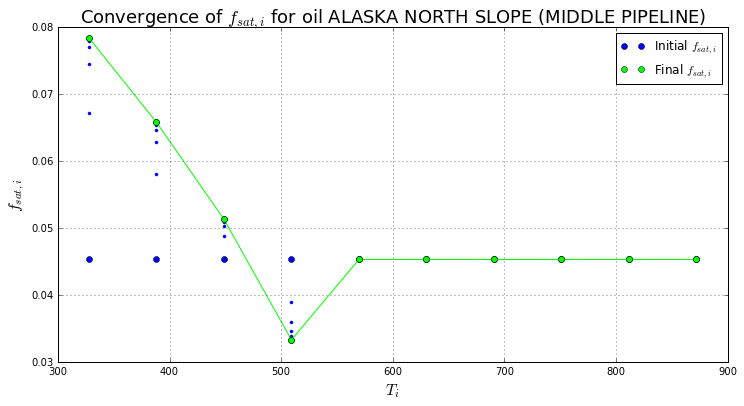

In [20]:
plt.figure(1, figsize=(12,6))
plt.subplot(111)

obj = ans_mp

plt.xlabel(r'$T_i$', fontsize=16)
plt.ylabel(r'$f_{sat,i}$', fontsize=16)
plt.grid()
plt.title(r'Convergence of $f_{{sat,i}}$ for oil {}'.format(obj.oil_name),
          fontsize=18)

#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
cut_temps, fmass_i = oil_normalized_cut_temps_fmasses(obj)

f_sat_i = fmass_i / 2.0
f_arom_i = fmass_i / 2.0

label=r'Initial $f_{sat,i}$'
color, linestyle, marker = 'b', 'None', 'o'
plt.plot(cut_temps, f_sat_i,
         color=color, linestyle=linestyle, marker=marker, label=label)

for i in range(20):
    color, linestyle, marker = 'b', 'None', '.'
    label=''

    f_sat_i, f_arom_i = verify_cut_fractional_masses(fmass_i, cut_temps,
                                                     f_sat_i, f_arom_i)

    plt.plot(cut_temps, f_sat_i,
             color=color, linestyle=linestyle, marker=marker, label=label)

color, linestyle, marker = '#00ff00', 'None', 'o'
label=r'Final $f_{sat,i}$'
plt.plot(cut_temps, f_sat_i,
         color=color, linestyle=linestyle, marker=marker, label=label)
color, linestyle, marker = '#00ff00', '-', 'o'
label=''
plt.plot(cut_temps, f_sat_i,
         color=color, linestyle=linestyle, marker=marker, label=label)

plt.legend(loc='upper right')


Well, our saturate fractions do seem to converge into values that indicate the following:

- There is an inversely proportional relationship with boiling point.  The trend looks more-or-less linear.
- The temperature at which we achieve a 50/50 mix of saturates and aromatics appears to be somewhere around $470^\circ K$.
- The temperature at which we have lost all saturates is somewhere between $600^\circ K$ and $630^\circ K$. 

But I can't be completely sure if this is how our saturates are supposed to behave.  For one thing, this would also indicate that the fraction of aromatics in our cuts would proportionally increase until about $600^\circ K$ or so, where the distilled fractions become 100% aromatics.  Again, I can't be sure if this is how aromatics are supposed to behave.

I think I will submit this line of thinking to Bill & Co. before actually putting this into our estimations code.

<center><b>--- End JamesM Comments ---</b></center>

## <u>Oil Miscellaneous Properties</u>

These are oil properties that can be computed based on the previous computations, and in some cases are simply assigned a default value.

### 22. Oil-Water Surface Tension:

If the imported oil record does not contain a value for surface tension, then we will estimate it from the oil's API:

$$
\begin{align}
\sigma_{o-w} &= \text{oil/water surface tension at } 288.15^\circ K \,\, (N/m) \cr
&= 0.001 \cdot (39 - 0.2571 \cdot API) \qquad \qquad \qquad \qquad \boldsymbol{(eq. 27)} \cr
\end{align}
$$

<i>
Reference: Baker, O. and W. Swerdloff (1956), Calculation of Surface Tensions - Finding the Surface Tension of Hydrocarbon Liquids, Oil Gas J. (2 January 1956) pp. 125
</i>

In [21]:
def o_w_surface_tension_from_api(api):
    if api is not None:
        return 0.001 * (39.0 - 0.2571 * api)
    else:
        return None

def oil_o_w_surface_tension(imported_rec):
    if (imported_rec.oil_water_interfacial_tension_n_m is not None and
            imported_rec.oil_water_interfacial_tension_ref_temp_k is not None):
        ow_st = imported_rec.oil_water_interfacial_tension_n_m
        ref_temp_k = imported_rec.oil_water_interfacial_tension_ref_temp_k

        return ow_st, ref_temp_k
    elif imported_rec.api is not None:
        ow_st = oil_water_surface_tension_from_api(imported_rec.api)

        return ow_st, 273.15 + 15
    else:
        est_api = api_from_density(oil_density_at_temp(imported_rec, 288.15))
        ow_st = oil_water_surface_tension_from_api(est_api)

        return ow_st, 273.15 + 15

#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'oil/water surface tension = ', o_w_surface_tension_from_api(obj.api)
    print 'oil/water surface tension = ', oil_o_w_surface_tension(obj)
    print

oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
oil/water surface tension =  0.03131271
oil/water surface tension =  (0.0238, 273.15)



### 23. Pour Point:

If the imported oil record contains a pour point property then we will simply use it when building the final oil record.<br>
Otherwise, if we have measured molecular weights for the distillation fractions (unusual) then use method <b>(A)</b>.<br>
Otherwise, use method <b>(B)</b>

<b>(A)</b> If molecular weight and mass fractions are given for all the oil fractions $j = 1 \dots jMAX$, then an average molecular weight for the whole oil $\bar M_w$ can be estimated as:

$$
\begin{align}
N &= \text{number of distillation cuts} \cr
jMAX &= 2 (N + 1) \cr
M_{w,j} &= \text{molecular weight of component j} (kg/kmole)\cr
fmass_j &= \text{mass fraction of component j} \cr
\cr
\bar M_w &= \sum_1^{jMAX} M_{w,j} \cdot fmass_j \qquad \qquad \qquad \qquad \boldsymbol{(eq. 28)} \cr
\end{align}
$$

<i>(Note: The calculation for $jMAX$ may seem counterintuitive. It simply states that we sum over all the SARA fractions, each distillation cut represents 1 saturate and 1 aromatic fraction, and that resins and asphaltenes do not have distillation cut data.  So for $N$ distillation cuts, we would calculate $2 N + 2 \rightarrow 2(N + 1)$)</i>

Define $SG = \rho_{oil} / 1000 \cdot kg$ as specific gravity

Then, using CPPF eq. 3.119, our pour point temperature is calculated as:

$$
\begin{align}
T_{API} &= \text{reference temperature for oil kinematic viscosity} \cr
&= 311^\circ K \cr
\cr
T_{pp} &= 130.47 SG^{2.97} \cdot \bar M_w^{0.61235 - 0.47357 SG} \cdot v_{oil}^{0.31 - 0.3283 SG} \cdot T_{API} \qquad \qquad \boldsymbol{(eq. 29)} \cr
\end{align}
$$

<b>(B)</b> Pour point is estimated by reversing the viscosity-temperature correction in Adios2 and assuming that, at the pour point, viscosity is equal to 1 million centistokes.

$$
\begin{align}
c_{v1} &= 5000 K \cr
\cr
T_{pp} &= { c_{v1} \cdot T_{ref} \over c_{v1} - T_{ref} ln(v_{ref}) }
\qquad \qquad \qquad \qquad \boldsymbol{(eq. 30)} \cr
\end{align}
$$

<center><b>--- Begin JamesM Comments ---</b></center>

In <b>(A)</b>, we reference CPPF eq. 3.119, which seems to not include $T_{API}$ as an input.  Riazi describes this equation as:

$$
\begin{align}
SG &= \text{oil specific gravity} \cr
M &= \text{oil molecular weight} \cr
v_{38(100)} &= \text{oil kinematic viscosity at } 37.8^\circ C (100^\circ F) \cr
\cr
T_P &= \text{pour point (ASTM D 97) in } \,^\circ K \cr
&= 130.47 [SG^{2.970566}] \cdot [M^{(0.61235 - 0.47357 SG)}] \cdot [v_{38(100)}^{(0.310331 - 0.32834 SG)}] \cr
\end{align}
$$

So I think that eq. 6 is not correct.

Beyond that, I think that we would only use this formula if we had actual measured component densities in our imported oil record, which is very unlikely.
The component molecular weights and densities that we estimate already use viscosity as an input, at least in part.  So I am not convinced that an estimation based on them would be any more accurate than <b>(B)</b>.

In <b>(B)</b>, exactly which $(T_{ref}, v_{ref})$ measurement should we use if multiple viscosity measurements exist?  Since we are calculating pour point, which I understand to mean the lowest temperature for which a finite viscosity exists, I believe we should use the lowest measured temperature and its associated viscosity.

Does the viscosity-temperature correction formula in Adios2 define what $c_{v1}$ is?

<center><b>--- End JamesM Comments ---</b></center>

In [22]:
def estimate_pour_point_from_kvis(ref_kvis, ref_temp_k):
    c_v1 = 5000.0
    T_pp = (c_v1 * ref_temp_k) / (c_v1 - ref_temp_k * np.log(ref_kvis))
    
    return T_pp

def oil_pour_point(imported_rec):
    min_k = max_k = None

    if (imported_rec.pour_point_min_k is not None or
            imported_rec.pour_point_max_k is not None):
        min_k = imported_rec.pour_point_min_k
        max_k = imported_rec.pour_point_max_k
    else:
        lowest_kvis = lowest_temperature(oil_aggregate_kvis(imported_rec)[0])
        max_k = pour_point_from_kvis(lowest_kvis.m_2_s, lowest_kvis.ref_temp_k)

    return min_k, max_k

# pour point estimation based on (T_ref, v_ref)
# seems a bit inaccurate
#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'oil.pour_point_min = ', obj.pour_point_min_k
    print 'oil.pour_point_max = ', obj.pour_point_max_k

    lowest_kvis = lowest_temperature(oil_aggregate_kvis(obj))
    ref_kvis, ref_temp_k = lowest_kvis.m_2_s, lowest_kvis.ref_temp_k
    print 'pour point (T_ref, v_ref) = ', estimate_pour_point_from_kvis(ref_kvis, ref_temp_k)

    print 'oil_pour_point() = ', oil_pour_point(obj)

    print


oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
oil.pour_point_min =  219.15
oil.pour_point_max =  219.15
pour point (T_ref, v_ref) =  175.598251438
oil_pour_point() =  (219.15, 219.15)



### 24. Flash Point:

If a measured minimum flash point exists for the incoming record, we will use it.<br>
Otherwise, if a measured maximum flash point exists for the incoming record, we will use that instead.<br>
Otherwise, if measured distillation cut data exists, use method <b>(A)</b>.<br>
Otherwise, use method <b>(B)</b>.

<b>(A)</b> Flash point can be estimated from the first pseudo-component cut:

$$
\begin{align}
T_{cut1} &= \text{the boiling point of the first pseudo-component cut } (^\circ K) \cr
\cr
T_{flsh} &= 117 + 0.69 \cdot T_{cut1} \qquad \qquad \qquad \qquad \boldsymbol{(eq. 31)} \cr
\end{align}
$$

<i>
Reference: Chang A., K. Pashakanti, and Y. Liu (2012), Integrated Process Modeling and Optimization, Wiley Verlag.
</i>

<b>(B)</b> Flash point can be estimated from the API value:

$$
\begin{align}
T_{flsh} &= 457 - 3.34 \cdot API \qquad \qquad \qquad \qquad \boldsymbol{(eq. 32)} \cr
\end{align}
$$

<center><b>--- Begin JamesM Comments ---</b></center>

I have some reservations about simply using the first distillation cut boiling point.<br>
It seems that the results could vary wildly depending on the quality of the cut data.

I would be much more confident in a curve fit to the cuts, in which we take the temperature where a certain fraction is evaporated.

<center><b>--- End JamesM Comments ---</b></center>

In [23]:
def estimate_flash_point_from_bp(ref_temp_k):
    return 117.0 + 0.69 * ref_temp_k

def estimate_flash_point_from_api(api):
    return 457.0 - 3.34 * api

def oil_flash_point(imported_rec):
    if imported_rec.flash_point_min_k is not None:
        return imported_rec.flash_point_min_k
    elif imported_rec.flash_point_max_k is not None:
        return imported_rec.flash_point_max_k
    elif len(list(oil_culled_cuts(imported_rec))) > 2:
        cut_temps = oil_normalized_cut_temps(imported_rec)
        return estimate_flash_point_from_bp(cut_temps[0])
    elif imported_rec.api is not None:
        return estimate_flash_point_from_api(imported_rec.api)
    else:
        est_api = estimate_api_from_density(oil_density_at_temp(imported_rec, 288.15))
        return estimate_flash_point_from_api(est_api)

# ANS oil has both an api and distillation cuts.
# For this oil, methods (A) and (B) estimate different results.
# but the difference is only about 7%.  Probably acceptable.
# we should try this on other oils to compare.

#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'oil.flash_point_min_k = ', obj.flash_point_min_k
    print 'oil.flash_point_max_k = ', obj.flash_point_max_k
    if len(list(oil_culled_cuts(obj))) > 0:
        print 'oil.cuts[0] = ', oil_normalized_cut_values(obj)[0][0]
    else:
        print 'no cut data'
    print 'oil.api = ', obj.api

    print 'oil flash point = ', oil_flash_point(obj)
    print

oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
oil.flash_point_min_k =  250.15
oil.flash_point_max_k =  250.15
oil.cuts[0] =  327.851614045
oil.api =  29.9
oil flash point =  250.15



### 25. Maximum water fraction of emulsion:

This quantity will be set after the emulsification approach in Adios3 is finalized.  It will vary depending upon the emulsion stability.  For now the following rule will be applied:

If our substance is a crude oil, then $f_{w max} = 0.9$<br>
If our substance is a refined product, then $f_{w max} = 0$

### 26. Bullwinkle (time):

Adios3 needs to know when to initiate emulsification.  The Adios2 development team called this term Bullwinkle.  SINTEF has measured this parameter for some oils, and the new, not yet completed, analysis of emulsification may provide formulas for Bullwinkle.  Bullwinkle may be either a time value (i.e. time delay after which the emulsification formulas are turned on) or a fraction of the oil that needs to evaporate or dissolve before emulsification can start.

Bullwinkle(time) is undefined unless the user explicitly sets a value.  Then it overrides Bullwinkle(fraction) as the determining parameter for the onset of emulsification.

### 27. Bullwinkle (fraction):

<i>
Reference: Adios2
</i>

Bullwinkle is the mass fraction that must evaporate or dissolve before stable emulsification can begin.  This formula will change when we complete the emulsification module.

If $f_{asph} > 0$, then we use method <b>(A)</b><br>
Otherwise, we use method <b>(B)</b><br>

<b>(A)</b> $f_{bull}$ can be calculated from $f_{asph}$:
$$
\begin{align}
f_{bull} &= 0.32 - 3.59 \cdot f_{asph} \qquad \qquad \qquad \boldsymbol{(eq. 33)} \cr
\end{align}
$$

<b>(B)</b> $f_{bull}$ can be calculated from the oil's API:
$$
\begin{align}
f_{bull} &= 0.5762 \cdot log10(API) - 0.6353 \qquad \qquad \boldsymbol{(eq. 34)} \cr
\end{align}
$$

A result of $f_{bull} < 0$ or $f_{bull} > 1$ indicates no emulsification.

<center><b>--- Begin JamesM Comments ---</b></center>

At this point in our estimations we should always have a reasonable, or at least consistent value for $f_{asph}$.<br>
I would say that we can nearly always choose formula <b>(A)</b>

<center><b>--- End JamesM Comments ---</b></center>

In [24]:
def estimate_bullwinkle_fraction_from_asph(f_asph):
    return 0.32 - 3.59 * f_asph

def estimate_bullwinkle_fraction_from_api(api):
    return 0.5762 * np.log10(api) - 0.6353

def oil_bullwinkle_fraction(imported_rec):
    _f_res, f_asph = oil_inert_fractions(imported_rec)

    if f_asph > 0.0:
        return estimate_bullwinkle_fraction_from_asph(f_asph)
    elif imported_rec.api is not None:
        return estimate_bullwinkle_fraction_from_api(imported_rec.api)
    else:
        est_api = api_from_density(oil_density_at_temp(imported_rec, 288.15))
        return estimate_bullwinkle_fraction_from_api(est_api)

#for obj in (ans_mp, ans_2002, bahia, arabian, canola):
for obj in (ans_mp,):
    print 'oil = ', obj.oil_name
    print 'oil.api = ', obj.api
    print 'oil.asphaltenes = ', obj.asphaltenes
    print 'oil.densities = ', obj.densities

    print 'bullwinkle(fraction) = ', oil_bullwinkle_fraction(obj)
    print


oil =  ALASKA NORTH SLOPE (MIDDLE PIPELINE)
oil.api =  29.9
oil.asphaltenes =  None
oil.densities =  [<Density(886.9 kg/m^3 at 273.15K)>, <Density(876.1 kg/m^3 at 288.15K)>]
bullwinkle(fraction) =  0.259049831898



### 28. Solubility:

If the imported oil record contains a valid value for solubility, we will use that value when building our oil.<br>
Otherwise, $c_{solu} = 0 \, kg/m^3$

### 29. Adhesion <i>(not currently used by model)</i>:

If the imported oil record contains a valid value for adhesion, we will use that value when building our oil.<br>
Otherwise, $Adh_{oil} = 0.035 \, kg/m^2$

<i>
Reference: ESTC data
</i>

### 30. Sulphur Mass Fraction <i>(not currently used by model)</i>:

If the imported oil record contains a valid value for sulphur mass fraction, we will use that value when building our oil.<br>
Otherwise, $f_{sulf} = 0$